<a href="https://colab.research.google.com/github/aalexakos/thesis-smart-grids/blob/main/analytics_predicted_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read Random Forest data

In [28]:
import pandas as pd
import datetime
import time
import numpy as np
from ast import literal_eval
from sklearn.metrics import *
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive/')

data_location = '/content/drive/MyDrive/alexakos-thesis/'

rf_csv=(f'{data_location}datasets/rf_predicted.csv') 
rf=pd.read_csv(rf_csv)
rf['datetime'] = pd.to_datetime(rf['datetime'], errors='coerce')
rf=rf.drop(columns=['climacell','temp_air','windSpeed','weatherCode','hour'])

rf

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,timestamp,altidute,predicted,datetime
0,1624089600,53.317024,3187.094059,2021-06-19 08:00:00
1,1623603600,10.120813,56.432087,2021-06-13 17:00:00
2,1624359600,73.643243,2985.848358,2021-06-22 11:00:00
3,1622908800,20.498933,312.337188,2021-06-05 16:00:00
4,1623834000,64.196235,3621.611040,2021-06-16 09:00:00
...,...,...,...,...
117,1624946400,29.675736,1735.881633,2021-06-29 06:00:00
118,1622552400,54.576421,2471.598781,2021-06-01 13:00:00
119,1622894400,65.418160,3380.050113,2021-06-05 12:00:00
120,1625050800,73.458266,3051.702370,2021-06-30 11:00:00


#read data from sensors and API's

In [29]:
csv=(f'{data_location}datasets/monthly_data.csv') 
df=pd.read_csv(csv)
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['hour']=df['datetime'].dt.hour.reset_index(drop=True)
df.drop(df[df.hour == 18].index, inplace=True)
# df.drop(df[df.hour == 17].index, inplace=True)
# df.drop(df[df.hour == 16].index, inplace=True)

df

,datetime,sensor_avg,active_power,openweathermap,timestamp,dni,dhi,climacell,temp_air,windSpeed,weatherCode,pySolar,altidute,p_solar_horizontal,horizontal_avg,openweather_modular,climacell_modular,modular_avg,hour
0,2021-06-01 03:00:00,23.467358,65.812500,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000,NaN,NaN,NaN,3
1,2021-06-01 04:00:00,69.214333,272.940000,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000,NaN,NaN,NaN,4
2,2021-06-01 05:00:00,259.855359,1089.745098,173.51,1.622524e+09,531.66,52.97,130.54,15.40,1.38,1101.0,584.774023,18.692675,553.927928,152.025,367.385244,276.401762,321.893503,5
3,2021-06-01 06:00:00,492.937133,2091.360000,368.24,1.622527e+09,708.14,76.03,307.79,17.40,0.78,1101.0,734.007108,30.147389,634.722612,338.015,574.312851,480.034088,527.173469,6
4,2021-06-01 07:00:00,695.443333,2893.392157,564.29,1.622531e+09,802.75,93.08,523.31,18.76,1.27,1100.0,810.078312,41.766524,604.209308,543.800,711.323696,659.665781,685.494738,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2021-06-30 12:00:00,686.347000,2792.366667,983.12,1.625054e+09,885.14,147.34,932.05,38.40,5.50,1000.0,864.640197,66.622376,343.080107,957.585,845.152187,801.249182,823.200684,12
706,2021-06-30 13:00:00,557.772333,2335.633333,905.95,1.625058e+09,859.37,149.51,847.44,36.20,3.78,1001.0,844.494669,56.261743,469.032177,876.695,911.891556,852.997826,882.444691,13
707,2021-06-30 14:00:00,332.617586,1419.206897,778.06,1.625062e+09,855.21,116.87,694.83,34.51,3.15,1000.0,807.505322,44.871977,572.266906,736.445,932.807248,833.023752,882.915500,14
708,2021-06-30 15:00:00,186.102583,781.466667,611.07,1.625065e+09,811.43,99.63,556.07,33.26,2.32,1000.0,741.934057,33.253899,620.441498,583.570,895.340363,814.754309,855.047336,15


In [30]:
df=df.merge(rf, how='right', on='timestamp').dropna()
df['weatherCode'] = df['weatherCode'].astype(int)
df

,datetime_x,sensor_avg,active_power,openweathermap,timestamp,dni,dhi,climacell,temp_air,windSpeed,weatherCode,pySolar,altidute_x,p_solar_horizontal,horizontal_avg,openweather_modular,climacell_modular,modular_avg,hour,altidute_y,predicted,datetime_y
0,2021-06-19 08:00:00,802.680750,3260.333333,682.60,1.624090e+09,645.56,205.92,652.91,26.29,2.08,1102,840.111463,53.317024,501.871576,667.755,718.341968,687.097354,702.719661,8,53.317024,3187.094059,2021-06-19 08:00:00
1,2021-06-13 17:00:00,26.034000,74.733333,171.74,1.623604e+09,314.12,87.39,128.20,22.56,2.07,1001,338.808806,10.120813,333.536741,149.970,559.338704,417.533608,488.436156,17,10.120813,56.432087,2021-06-13 17:00:00
2,2021-06-22 11:00:00,824.285333,3118.000000,1002.49,1.624360e+09,864.61,170.37,866.68,33.88,2.80,1100,875.227927,73.643243,246.479364,934.585,771.097642,666.634983,718.866312,11,73.643243,2985.848358,2021-06-22 11:00:00
3,2021-06-05 16:00:00,76.965083,314.900000,314.84,1.622909e+09,334.65,167.06,336.78,23.08,2.41,1101,612.817474,20.498933,574.013083,325.810,627.646903,671.385224,649.516063,16,20.498933,312.337188,2021-06-05 16:00:00
4,2021-06-16 09:00:00,932.834483,3705.896552,878.97,1.623834e+09,852.84,148.38,839.86,25.46,3.10,1000,865.559245,64.196235,376.769514,859.415,784.412299,749.509669,766.960984,9,64.196235,3621.611040,2021-06-16 09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2021-06-29 06:00:00,420.071667,1796.066667,358.61,1.624946e+09,700.73,74.40,318.03,27.11,0.30,1000,712.411681,29.675736,618.972657,338.320,564.906571,500.982228,532.944400,6,29.675736,1735.881633,2021-06-29 06:00:00
118,2021-06-01 13:00:00,703.120733,3046.420000,893.37,1.622552e+09,864.02,145.21,718.67,23.37,6.17,1102,856.037927,54.576421,496.173774,806.020,922.405809,742.027808,832.216809,13,54.576421,2471.598781,2021-06-01 13:00:00
119,2021-06-05 12:00:00,789.242913,3321.718750,339.26,1.622894e+09,19.37,321.12,876.92,27.02,4.58,1001,874.878104,65.418160,363.942800,608.090,297.129243,768.020325,532.574784,12,65.418160,3380.050113,2021-06-05 12:00:00
120,2021-06-30 11:00:00,863.249417,3339.566667,1003.22,1.625051e+09,884.08,153.75,948.74,39.27,3.79,1000,873.017987,73.458266,248.560151,975.980,773.977894,731.946918,752.962406,11,73.458266,3051.702370,2021-06-30 11:00:00


#Analytics per hour for Random Forest


In [31]:
errors = pd.DataFrame(columns=['hour','active_power/machine_learning_power'])
errors['hour']=df['hour']
errors=errors.drop_duplicates()
errors=errors.sort_values(by='hour', ignore_index=True).reset_index(drop=True)

In [32]:
#Error % (park acive power) vs  (ML)
sensor=[]
rf=[]
for hour_new in errors['hour']:
  for i,hour in enumerate(df.hour):
    if (hour_new == hour): 
      sensor.append(df.iloc[i].active_power)
      rf.append(df.iloc[i].predicted)
  errors.loc[errors['hour'] == hour_new, 'active_power/machine_learning_power'] = abs(sum(rf)-sum(sensor))/sum(sensor)*100
  rf.clear()      
  sensor.clear()

Text(0.5, 0, 'hour')

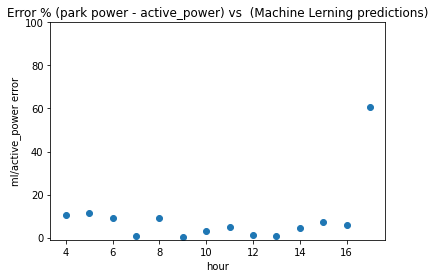

In [33]:
plt.scatter(errors.hour,errors['active_power/machine_learning_power'])
ax = plt.gca()
ax.set_ylim([-1, 100])
plt.title("Error % (park power - active_power) vs  (Machine Lerning predictions)")
plt.ylabel("ml/active_power error")
plt.xlabel("hour")

In [34]:
errors

,hour,active_power/machine_learning_power
0,4,10.4129
1,5,11.5676
2,6,9.00944
3,7,0.64468
4,8,9.2647
5,9,0.120886
6,10,3.01176
7,11,5.11988
8,12,1.12111
9,13,0.546137


#Analytics per weather code for Random Forest


In [35]:
#export discrete weather codes
wcode_errors = pd.DataFrame(columns=['weather_code','active_power/machine_learning_power'])
wcode_errors['weather_code']=df['weatherCode']
wcode_errors=wcode_errors.drop_duplicates()
wcode_errors.sort_values(by='weather_code', ignore_index=True)
wcode_errors

,weather_code,active_power/machine_learning_power
0,1102,NaN
1,1001,NaN
2,1100,NaN
3,1101,NaN
4,1000,NaN
44,4000,NaN
87,4200,NaN


Text(0.5, 1.0, 'Error % (park active power) vs  (predicted_power) per weather code')

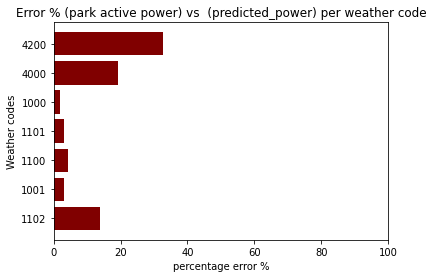

In [36]:
sensor=[]
predicted_temp=[]
for code in wcode_errors['weather_code']:
  for i,weatherCode in enumerate(df.weatherCode):
    if (code == weatherCode): 
      sensor.append(df.iloc[i].active_power)
      predicted_temp.append(df.iloc[i].predicted)
  wcode_errors.loc[wcode_errors['weather_code'] == code, 'active_power/machine_learning_power'] = abs(sum(predicted_temp)-sum(sensor))/sum(sensor)*100
  sensor.clear()
  predicted_temp.clear()
wcode_errors['weather_code']=wcode_errors['weather_code'].map(str)

# creating the bar plot
plt.barh(wcode_errors.weather_code, wcode_errors['active_power/machine_learning_power'], color='maroon')
ax = plt.gca()
ax.set_xlim([0, 100])
plt.ylabel("Weather codes")
plt.xlabel("percentage error %")
plt.title("Error % (park active power) vs  (predicted_power) per weather code")


#Campare predictions from ML and PvLib per weather code

In [37]:
csv=(f'{data_location}datasets/pvlib_errors_weather.csv') 
pvlib_errors_weather=pd.read_csv(csv)
pvlib_errors_weather

,weather_code,p_mp/active_power,adapted_power/activePower
0,1101,22.393387,1.162109
1,1100,19.768350,2.404926
2,1102,20.849075,16.035336
3,1001,16.530217,9.351474
4,1000,28.492430,4.791128
5,4000,62.212653,4.213568
6,4200,142.078992,20.272881


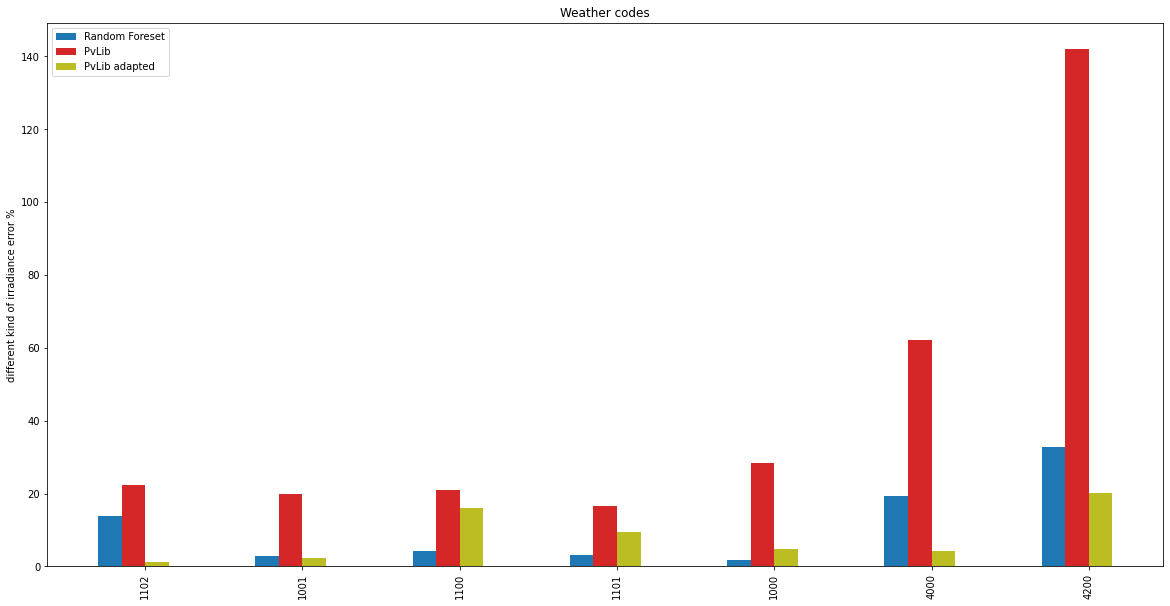

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))

# A little data preparation
years = wcode_errors.weather_code
x = np.arange(len(years))

width=0.15

# Plot each bar plot. Note: manually calculating the 'dodges' of the bars
ax.bar(x - 3*width/2, wcode_errors['active_power/machine_learning_power'], width, label='Random Foreset', color='tab:blue')
ax.bar(x - width/2, pvlib_errors_weather['p_mp/active_power'], width, label='PvLib', color='tab:red')
ax.bar(x + width/2, pvlib_errors_weather['adapted_power/activePower'], width, label='PvLib adapted', color='tab:olive')


# Customise some display properties
ax.set_ylabel('different kind of irradiance error %')
ax.set_title('Weather codes')
ax.set_xticks(x)    # This ensures we have one tick per year, otherwise we get fewer
ax.set_xticklabels(years.astype(str).values, rotation='vertical')
ax.legend()

# Ask Matplotlib to show the plot
plt.show()

In [39]:
csv=(f'{data_location}datasets/pvlib_errors_hour.csv') 
pvlib_errors_hour=pd.read_csv(csv)
pvlib_errors_hour

,hour,p_mp/active_power,adapted_power/activePower
0,4,65.648215,13.390692
1,5,15.412851,88.756060
2,6,0.966420,0.362366
3,7,10.267978,0.598544
4,8,6.921686,4.875208
5,9,16.513831,2.730632
6,10,24.634961,2.275004
7,11,29.486109,4.876559
8,12,42.518143,4.579964
9,13,52.362026,6.131976


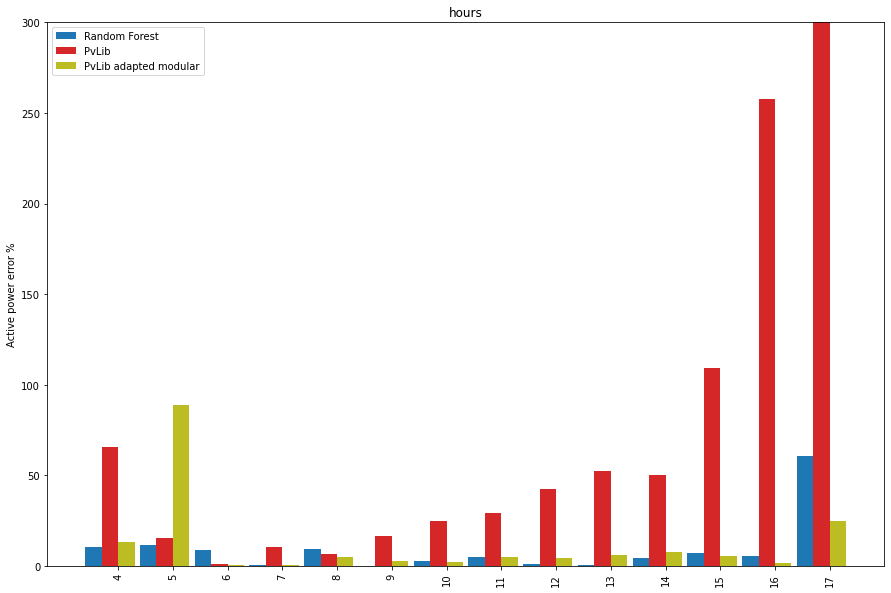

In [40]:
fig, ax = plt.subplots(figsize=(15, 10))

# A little data preparation
years = errors.hour
x = np.arange(len(years))

width=0.3

# Plot each bar plot. Note: manually calculating the 'dodges' of the bars
ax.bar(x - 3*width/2, errors['active_power/machine_learning_power'], width, label='Random Forest', color='tab:blue')
ax.bar(x - width/2, pvlib_errors_hour['p_mp/active_power'], width, label='PvLib', color='tab:red')
ax.bar(x + width/2, pvlib_errors_hour['adapted_power/activePower'], width, label='PvLib adapted modular', color='tab:olive')

# Customise some display properties
ax.set_ylabel('Active power error %')
ax.set_title('hours')
ax.set_xticks(x)    # This ensures we have one tick per year, otherwise we get fewer
ax.set_xticklabels(years.astype(str).values, rotation='vertical')
ax.legend()
ax.set_ylim([0, 300])

# Ask Matplotlib to show the plot
plt.show()